# import packages- I used google colab fro running this notebook

In [111]:
!pip install catboost

In [112]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve, roc_auc_score,average_precision_score,log_loss, brier_score_loss
from sklearn.tree import plot_tree
from catboost import CatBoostClassifier, Pool, EFstrType

# Data Load

In [113]:
import pandas as pd, csv
df_bid = pd.read_csv(
    "data_assignment.csv",
    sep=",",
    engine="python",
    quoting=csv.QUOTE_MINIMAL,
    on_bad_lines="warn"  # or "skip" to drop malformed lines
)
print(df_bid.shape)

(249232, 26)


In [114]:
df_bid.head()

,time,user_id,domain,url,ad_slot,country,postal_code,state_code,city,user_agent,...,publisher_properties,is_wifi,viewability,session_depth,auction_type,bidded,bid,won_bid,feedback_bid,conversion
0,2021-02-01 11:55:21.069787 UTC,f8e41a1c-efdb-46b1-b2d9-3aeb72bba89d,7aabe8b27435bfd7668d04176b337c08,af92ed8eeaf378c6389283a8a20ba478,561992fb3807332dcd12e628d323f35f,US,NaN,CA,Los Angeles,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0...",...,ce42601122277fac98e2e7d9ffdd8bdf,1,2,21,FIRST_PRICE,0,NaN,NaN,NaN,NaN
1,2021-02-01 14:21:20.709435 UTC,a1d669db-cf66-4115-9c77-7ab1b3dd85d1,eef257c10f357553e1db9ba79a9df8ca,d1d8815b6aba214f4f97c005908b2eb4,fc962fde231a7ea7c7816fc83e817d51,US,67301,NaN,NaN,[FBAN/FB4A;FBAV/302.0.0.45.119;FBBV/268946157;...,...,1387decec8e3554f17b8e85a42989496,1,19,1,FIRST_PRICE,0,NaN,NaN,NaN,NaN
2,2021-02-01 13:17:28.357954 UTC,f4fb32a2-04a4-43ce-bdbd-923180e382ff,eef257c10f357553e1db9ba79a9df8ca,f8cf25b6d6947262f84d6fc47cbe1103,fc962fde231a7ea7c7816fc83e817d51,US,NaN,NaN,NaN,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803434;...,...,1387decec8e3554f17b8e85a42989496,1,25,-1,FIRST_PRICE,0,NaN,NaN,NaN,NaN
3,2021-02-01 14:29:40.855833 UTC,1b0fd751-8cf5-4c54-bdea-4e92b498eb36,eef257c10f357553e1db9ba79a9df8ca,d0ed5d14c6d8f7517943aae0ffa8c087,fc962fde231a7ea7c7816fc83e817d51,US,67335,NaN,NaN,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803868;...,...,1387decec8e3554f17b8e85a42989496,1,22,1,FIRST_PRICE,0,NaN,NaN,NaN,NaN
4,2021-02-01 09:03:40.056427 UTC,24a0dda3-bcba-4e60-91f7-0916a3f180bf,d62c4ae0304db7527a61b19f9149a189,5194f552aea6dea598a2b57cde4fb77e,e9c20ff10ceb2f62d0a2891a6277668f,US,NaN,NaN,NaN,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803893;...,...,97cde7e5c320944ad56c85f2a8858e7f,1,44,2,FIRST_PRICE,1,0.678901,1.0,0.51,0.0


#Question 1-EDA

####check the type of the columns

In [115]:
df_bid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249232 entries, 0 to 249231
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  249232 non-null  object 
 1   user_id               249232 non-null  object 
 2   domain                249222 non-null  object 
 3   url                   249232 non-null  object 
 4   ad_slot               249232 non-null  object 
 5   country               249232 non-null  object 
 6   postal_code           201974 non-null  object 
 7   state_code            240773 non-null  object 
 8   city                  236697 non-null  object 
 9   user_agent            249194 non-null  object 
 10  cookie_age_seconds    249232 non-null  int64  
 11  detected_language     249033 non-null  object 
 12  device_type           249232 non-null  object 
 13  device_brand          111686 non-null  object 
 14  device_model          111687 non-null  object 
 15  

#### count unique values

In [116]:
# the user_id  is unique per row and country ( US only) and screen_orientation(UNKNOWN_ORIENTATION ) ar econstant
# we will drop these three columns from our model because they are not meaningful for the model

In [117]:
df_bid.nunique()

,0
time,248738
user_id,249232
domain,8635
url,44208
ad_slot,35255
country,1
postal_code,19596
state_code,51
city,7994
user_agent,20657


#### count df where we placed bid

In [118]:
num_of_rows_with_bid= df_bid[~df_bid['bid'].isnull()].shape[0]

In [119]:
print('number of rows with bid is ',num_of_rows_with_bid, 'the precent from the total dataset ',round(num_of_rows_with_bid/len(df_bid),3), '%')

number of rows with bid is  124152 the precent from the total dataset  0.498 %


#### count null values per columns

In [120]:
df_bid.isnull().sum().reset_index().rename(columns={0: 'count_nulls'}).query('count_nulls>0')

,index,count_nulls
2,domain,10
6,postal_code,47258
7,state_code,8459
8,city,12535
9,user_agent,38
11,detected_language,199
13,device_brand,137546
14,device_model,137545
16,publisher_properties,68
22,bid,125080


In [121]:
# count nulls where there is a bid

In [122]:
df_bid[~df_bid['bid'].isnull()].isnull().sum().reset_index().rename(columns={0: 'count_nulls'}).query('count_nulls>0')

,index,count_nulls
6,postal_code,24644
7,state_code,3803
8,city,6073
9,user_agent,18
11,detected_language,102
13,device_brand,62740
14,device_model,62744
16,publisher_properties,47
24,feedback_bid,2


In [123]:
df_bid.describe()

,cookie_age_seconds,is_wifi,viewability,session_depth,bidded,bid,won_bid,feedback_bid,conversion
count,2.492320e+05,249232.000000,249232.000000,249232.000000,249232.000000,124152.000000,124152.000000,124150.000000,124152.000000
mean,8.914815e+06,0.926615,56.853787,11.164782,0.498138,4.133353,0.375040,4.837522,0.035183
std,1.439282e+07,0.260769,32.712160,40.078729,0.499998,20.868548,0.484135,26.679007,0.184242
min,0.000000e+00,0.000000,-1.000000,-1.000000,0.000000,0.060000,0.000000,0.010000,0.000000
25%,0.000000e+00,1.000000,32.000000,-1.000000,0.000000,0.301924,0.000000,0.500000,0.000000
50%,2.592000e+05,1.000000,67.000000,-1.000000,0.000000,0.740403,0.000000,1.410000,0.000000
75%,1.296000e+07,1.000000,84.000000,2.000000,1.000000,1.830171,1.000000,3.290000,0.000000
max,6.220800e+07,1.000000,100.000000,303.000000,1.000000,700.000000,1.000000,1243.750000,1.000000


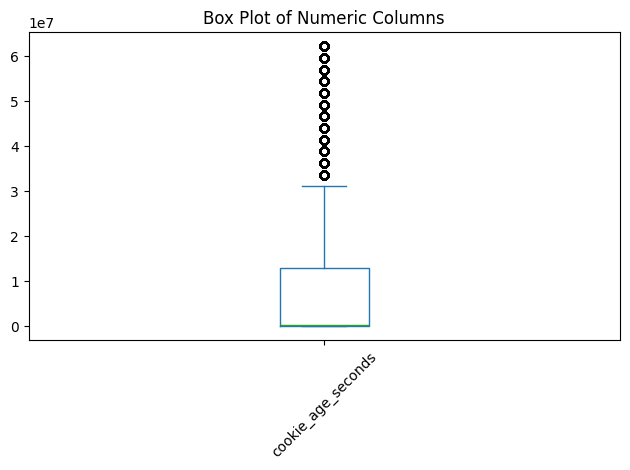

In [124]:
# check anomlies in the  cookie_age_seconds
# there are few abnormal values in this column, maybe we think on changing them if we will get incorrect prediction
df_bid['cookie_age_seconds'].plot.box()
plt.title("Box Plot of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

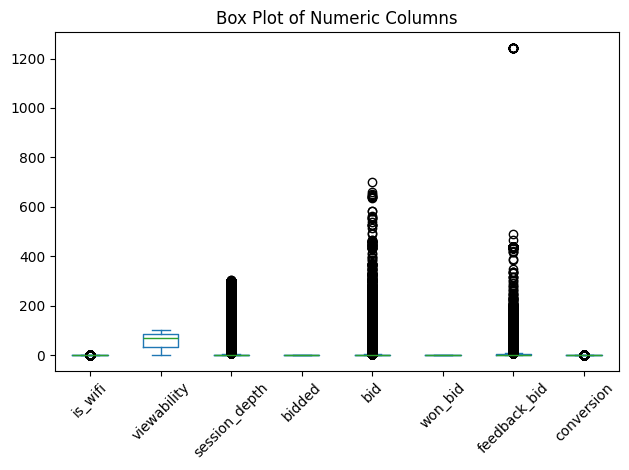

In [125]:
#check anomlies in the other numeric column excpet from cookie_age_seconds
#in columns session depth, bid and feedback_bid there are many abnormal values, so we will not change them
df_bid.loc[:,df_bid.columns != 'cookie_age_seconds'].plot.box()
plt.title("Box Plot of Numeric Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### time column analayze

In [126]:
# change column to datetime
df_bid["time_1"] = pd.to_datetime(df_bid["time"], utc=True, errors="coerce")

In [127]:
df_bid.time_1.dtype

datetime64[ns, UTC]

In [128]:
df_bid.time_1.dt.date.unique()

array([datetime.date(2021, 2, 1)], dtype=object)

In [129]:
df_bid.time_1.dt.hour.nunique()

24

# user agent column, extarct info not in device_type, device_brand, device_model

In [130]:
# we can extract additional columns but I focused on one column

In [131]:
df_bid.head()[['user_agent', 'device_type','device_brand','device_model' ]]

,user_agent,device_type,device_brand,device_model
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0...",PERSONAL_COMPUTER,NaN,NaN
1,[FBAN/FB4A;FBAV/302.0.0.45.119;FBBV/268946157;...,HIGHEND_PHONE,motorola,xt1789-05
2,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803434;...,HIGHEND_PHONE,samsung,sm-g781v
3,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803868;...,TABLET,samsung,sm-t510
4,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803893;...,HIGHEND_PHONE,google,pixel 3 xl


In [132]:
# function  client_family categorize the browser or app the bid offer to publish
def client_family(ua) :
    s = str(ua)
    if 'Instagram' in s:
        return 'instagram_app'
    if 'FBAN/' in s or 'FBAV/' in s or 'FBPN/com.facebook.katana' in s:
        return 'facebook_app'
    if 'Pinterest/' in s or '[Pinterest/' in s:
        return 'pinterest_app'
    if re.search(r'(?:Chrome|CriOS)/', s):
        return 'chrome'
    if 'Safari/' in s and 'Chrome/' not in s and 'CriOS/' not in s:
        return 'safari'
    if 'Firefox/' in s:
        return 'firefox'
    if re.search(r'(?:Edg|Edge)/', s):
        return 'edge'
    if 'OPR/' in s or 'Opera' in s:
        return 'opera'
    return 'other'

df_bid['client_family'] = df_bid['user_agent'].fillna('').map(client_family)

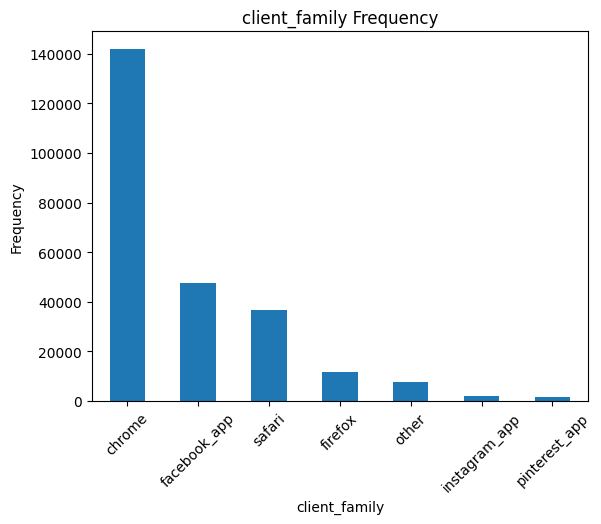

In [133]:
df_bid['client_family'].value_counts().plot(kind='bar', title='client_family Frequency')
plt.xticks(rotation=45)
plt.xlabel('client_family')
plt.ylabel('Frequency')
plt.show()

In [134]:
# auction_type change to binary

In [135]:
df_bid['auction_type_1']=np.where(df_bid.auction_type=='FIRST_PRICE',0,1)

In [136]:
df_bid['auction_type_1'].unique()

array([0, 1])

In [137]:
#### add delta between feedback_bid and bid, even in the "SECOND_PRICE" option the feedback_bid if we lost is the second higest price and not the best proposal differetly from FIRST_PRICE

In [138]:
df_bid['delta_feedback_bid']=df_bid['bid']-df_bid['feedback_bid']

In [139]:
df_bid['delta_feedback_bid'].unique()

array([      nan,  0.168901, -0.981133, ...,  0.146708,  0.177976,
       -2.272714])

#### correlation on specific columns

In [140]:
# get correlation for numeric columns

In [141]:
def print_corr_numeric(df,num_col):
  corr_matrix = df[num_cols].corr(numeric_only=True, method='pearson')
  print('correlation matrix')
  display(corr_matrix)

  print ('\ncorrelation of each numeric feature with conversion')
  conv_corr = df.loc[df.won_bid==1,num_cols].corrwith(df.loc[df.won_bid==1,'conversion']).sort_values(key=np.abs, ascending=False)
  print(conv_corr)

  print ('\ncorrelation of each numeric feature with won_bid')
  won_corr = df.loc[~df.won_bid.isnull(),num_cols].corrwith(df.loc[~df.won_bid.isnull(),'won_bid']).sort_values(key=np.abs, ascending=False)
  print(won_corr)

In [142]:
num_cols  = ['cookie_age_seconds','viewability','session_depth','bid','feedback_bid','is_wifi','auction_type_1','bidded','delta_feedback_bid','won_bid','conversion']

In [143]:
print_corr_numeric(df_bid,num_cols)

correlation matrix


,cookie_age_seconds,viewability,session_depth,bid,feedback_bid,is_wifi,auction_type_1,bidded,delta_feedback_bid,won_bid,conversion
cookie_age_seconds,1.000000,0.005963,0.099197,0.030586,0.025968,-0.094346,-0.006843,0.000976,-0.001919,-0.065373,-0.004324
viewability,0.005963,1.000000,-0.036927,0.073287,0.055631,-0.000658,-0.010438,0.043073,0.001594,0.020655,0.090426
session_depth,0.099197,-0.036927,1.000000,-0.035035,-0.018672,0.012658,-0.059947,-0.083939,-0.008215,0.016615,-0.036384
bid,0.030586,0.073287,-0.035035,1.000000,0.307869,0.032165,0.463129,NaN,0.446183,0.185908,0.123856
feedback_bid,0.025968,0.055631,-0.018672,0.307869,1.000000,0.011664,0.159328,NaN,-0.714107,-0.010454,0.025365
is_wifi,-0.094346,-0.000658,0.012658,0.032165,0.011664,1.000000,0.015743,-0.051424,0.012694,0.054453,-0.008020
auction_type_1,-0.006843,-0.010438,-0.059947,0.463129,0.159328,0.015743,1.000000,-0.047034,0.190890,0.310751,0.116107
bidded,0.000976,0.043073,-0.083939,NaN,NaN,-0.051424,-0.047034,1.000000,NaN,NaN,NaN
delta_feedback_bid,-0.001919,0.001594,-0.008215,0.446183,-0.714107,0.012694,0.190890,NaN,1.000000,0.146623,0.067271
won_bid,-0.065373,0.020655,0.016615,0.185908,-0.010454,0.054453,0.310751,NaN,0.146623,1.000000,0.246507



correlation of each numeric feature with conversion
conversion            1.000000
viewability           0.140046
bid                   0.082387
feedback_bid          0.081639
delta_feedback_bid    0.066564
session_depth        -0.055291
auction_type_1        0.045539
is_wifi              -0.040679
cookie_age_seconds    0.021048
bidded                     NaN
won_bid                    NaN
dtype: float64

correlation of each numeric feature with won_bid
won_bid               1.000000
auction_type_1        0.310751
conversion            0.246507
bid                   0.185908
delta_feedback_bid    0.146623
cookie_age_seconds   -0.065373
is_wifi               0.054453
viewability           0.020655
session_depth         0.016615
feedback_bid         -0.010454
bidded                     NaN
dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [144]:
# by the correlation above we can see the numeric features has low correlation with the conversion

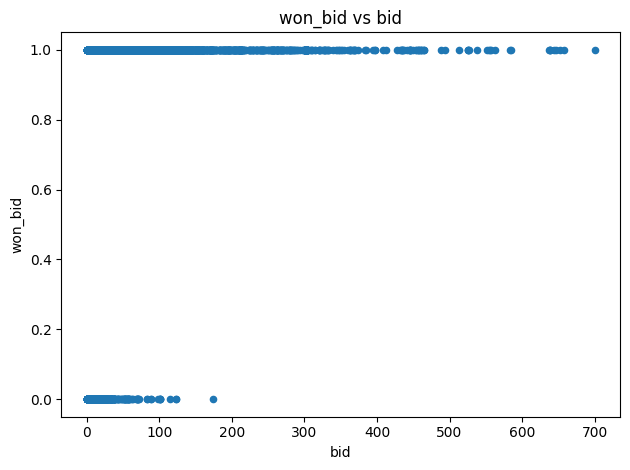

In [145]:
# by the graph below we can see when the bid is higher than 200 we won the bid
df_bid[~df_bid.won_bid.isnull()].plot.scatter(x='bid', y='won_bid', title='won_bid vs bid')
plt.tight_layout()
plt.show()

the frequency of first target value - conversion

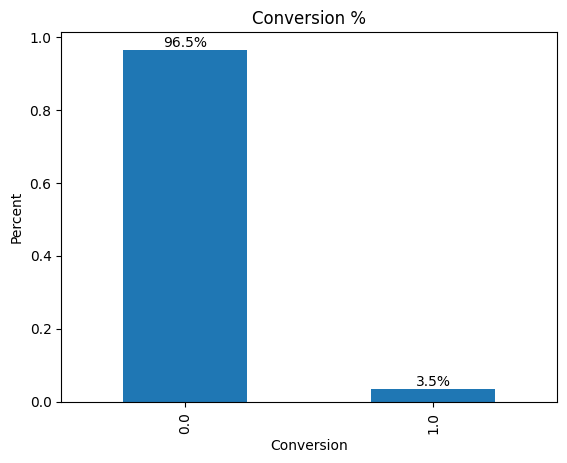

In [146]:
# by the histogram below I can see the precentage of the conversion is very low, but we need to verify the connection between won_bid and conversion
ax=(df_bid.conversion.value_counts(normalize=True).plot(kind='bar', title='Conversion %'))
ax.set_xlabel('Conversion')
ax.set_ylabel('Percent')
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.show()

In [147]:
# we can see the connection between conversion and won_bid, so if we didn't win the bid there is no conversion
# therefore when we try to predict the conversion we need to filter rows where won_bid is 1, if we don't win necessary there will no conversion
df_bid[['conversion','won_bid']].drop_duplicates()

,conversion,won_bid
0,NaN,NaN
4,0.0,1.0
9,0.0,0.0
146,1.0,1.0


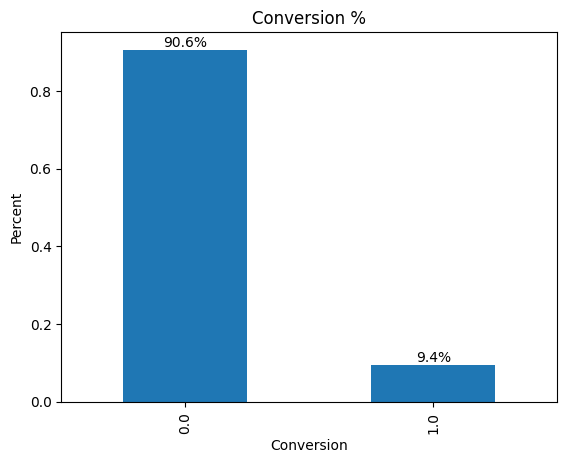

In [148]:
# by the histogram below I can see the prcentage is better balance but  data is still imbalance
ax=(df_bid[df_bid.won_bid==1].conversion.value_counts(normalize=True).plot(kind='bar', title='Conversion %'))
ax.set_xlabel('Conversion')
ax.set_ylabel('Percent')
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.show()

the frequency of second target value - won_bid

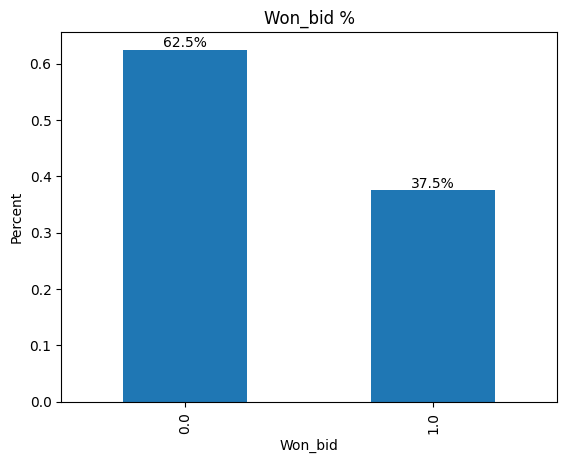

In [149]:
# by the histogram below I can see the data is pretty balalnce
ax=(df_bid.won_bid.value_counts(normalize=True).plot(kind='bar', title='Won_bid %'))
ax.set_xlabel('Won_bid')
ax.set_ylabel('Percent')
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
plt.show()

# Data preperation

In [150]:
df_bid.head(1).T

,0
time,2021-02-01 11:55:21.069787 UTC
user_id,f8e41a1c-efdb-46b1-b2d9-3aeb72bba89d
domain,7aabe8b27435bfd7668d04176b337c08
url,af92ed8eeaf378c6389283a8a20ba478
ad_slot,561992fb3807332dcd12e628d323f35f
country,US
postal_code,NaN
state_code,CA
city,Los Angeles
user_agent,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0..."


####time split to columns

In [151]:
# split time columns into hour and minute
def time_split(df,column):
    if column not in df.columns : return(print('No such column in dataframe'))

    df[column+'_hour'] = df[column].dt.hour
    df[column+'_minute'] = df[column].dt.minute

    return

In [152]:
time_split(df_bid,'time_1')

In [153]:
df_bid.head(1).T

,0
time,2021-02-01 11:55:21.069787 UTC
user_id,f8e41a1c-efdb-46b1-b2d9-3aeb72bba89d
domain,7aabe8b27435bfd7668d04176b337c08
url,af92ed8eeaf378c6389283a8a20ba478
ad_slot,561992fb3807332dcd12e628d323f35f
country,US
postal_code,NaN
state_code,CA
city,Los Angeles
user_agent,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0..."


### filter df by won_bid equal 1

In [154]:
df_bid_conv=df_bid[df_bid['won_bid']==1].copy()

In [155]:
df_bid_conv.shape

(46562, 32)

### update null values

In [156]:
# columns with nulls after the filter
df_bid_conv.isnull().sum().reset_index().rename(columns={0: 'count_nulls'}).query('count_nulls>0')

,index,count_nulls
6,postal_code,8874
7,state_code,1723
8,city,2403
9,user_agent,9
11,detected_language,36
13,device_brand,25116
14,device_model,25119
16,publisher_properties,15
24,feedback_bid,2
29,delta_feedback_bid,2


In [157]:
# change postal_code from text  to numeric
df_bid_conv['postal_code']=pd.to_numeric(df_bid_conv['postal_code'], errors='coerce')

In [158]:
# i fill nulls with zero or other in most of columns excpet from feedback_bid where there is just two rows, becuase we have enough rows for the models
# user_agent column will be removed from the model so we don't care about the nulls

def apply_na_strategy(df):
    """
    Fills null values in specific columns of the DataFrame based on predefined logic. and remove where there are few rows with nulls

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with null values filled.
    """

    # Fill nulls in 'postal_code' with 0
    df['postal_code'] = df['postal_code'].fillna(0)

    text_columns=['state_code','city','detected_language','device_brand','device_model','publisher_properties']
    # Fill nulls in text columns with other
    for col in text_columns:
        df[col] = df[col].fillna('other')

    # fillter out row without
    df=df[~(df.feedback_bid.isnull())].copy()
    display(df.isnull().sum().reset_index().rename(columns={0: 'count_nulls'}).query('count_nulls>0'))
    print(df.shape)
    return df

In [159]:
df_bid_conv=apply_na_strategy(df_bid_conv)

,index,count_nulls
9,user_agent,9


(46560, 32)


### update categorial columns

In [160]:
df_bid_conv.nunique()

,0
time,46557
user_id,46560
domain,1592
url,5589
ad_slot,4316
country,1
postal_code,12476
state_code,52
city,5196
user_agent,6564


In [161]:
# update two columns with  4/7 options with one hot codding

In [162]:
cols_one_hot=['client_family','device_type']

In [163]:
for col in cols_one_hot:
  df_bid_conv = df_bid_conv.join(
      pd.get_dummies(df_bid_conv[col], prefix=col, dtype=int)
  )

In [164]:
df_bid_conv[['device_type','device_type_GAME_CONSOLE','device_type_HIGHEND_PHONE','device_type_PERSONAL_COMPUTER','device_type_TABLET']].head()

,device_type,device_type_GAME_CONSOLE,device_type_HIGHEND_PHONE,device_type_PERSONAL_COMPUTER,device_type_TABLET
4,HIGHEND_PHONE,0,1,0,0
14,PERSONAL_COMPUTER,0,0,1,0
15,PERSONAL_COMPUTER,0,0,1,0
38,PERSONAL_COMPUTER,0,0,1,0
100,PERSONAL_COMPUTER,0,0,1,0


In [165]:
df_bid_conv.loc[:,df_bid_conv.columns.str.contains('client_family')].head()

,client_family,client_family_chrome,client_family_facebook_app,client_family_firefox,client_family_instagram_app,client_family_other,client_family_pinterest_app,client_family_safari
4,facebook_app,0,1,0,0,0,0,0
14,chrome,1,0,0,0,0,0,0
15,other,0,0,0,0,1,0,0
38,other,0,0,0,0,1,0,0
100,other,0,0,0,0,1,0,0


In [166]:
df_bid_conv.shape

(46560, 43)

In [167]:
# update categorial with the mean conversion per categorial column
# in order to avoid data leackage we will filter the time by the time we will divided between train and test dfs

In [168]:
cols_categorial_mean_target=['domain','url','ad_slot','postal_code','state_code','city','detected_language','device_brand','device_model','publisher_properties']

In [169]:
def get_time_split(df, train_frac):
  df=df.sort_values('time_1').reset_index()
  # split by row count
  n = len(df)
  split_idx = int(np.floor(n * train_frac))-1
  time_split=df.loc[split_idx,'time_1']
  print ( 'shape of train is ',df[df['time_1']<time_split].shape)
  print ( 'shape of test is ',df[df['time_1']>=time_split].shape)
  return time_split

In [170]:
time_split=get_time_split(df_bid_conv,0.7)

shape of train is  (32590, 44)
shape of test is  (13970, 44)


In [171]:
def update_categorial_with_mean(df,cols_categorial,y_col,time_split):
  df_train=df[df['time_1']<time_split].copy()
  overall_mean = df_train[y_col].mean()
  for col in cols_categorial:
      df_agg = df_train.groupby(col)[y_col].mean()
      df[col+'_1']=df[col].map(df_agg)
      df[col+'_1']=df[col+'_1'].fillna(overall_mean)
  return


In [172]:
update_categorial_with_mean(df_bid_conv,cols_categorial_mean_target,'conversion',time_split)

In [173]:
df_bid_conv.head(1).T

,4
time,2021-02-01 09:03:40.056427 UTC
user_id,24a0dda3-bcba-4e60-91f7-0916a3f180bf
domain,d62c4ae0304db7527a61b19f9149a189
url,5194f552aea6dea598a2b57cde4fb77e
ad_slot,e9c20ff10ceb2f62d0a2891a6277668f
country,US
postal_code,0.0
state_code,other
city,other
user_agent,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803893;...


### column to use for the model

In [174]:
df_bid_conv.columns[df_bid_conv.columns.str.contains('_1')]

Index(['time_1', 'auction_type_1', 'time_1_hour', 'time_1_minute', 'domain_1',
       'url_1', 'ad_slot_1', 'postal_code_1', 'state_code_1', 'city_1',
       'detected_language_1', 'device_brand_1', 'device_model_1',
       'publisher_properties_1'],
      dtype='object')

In [175]:
# removed the column of ID , all the text columns which I used the group the target value
# and regardin TarichHathala I used the columns I split it and get a ll the OneHotEncoding from  YeshuvAvoda
# removed the columns:  bidded, won_bid because thate is only one value
numeric_cols=['cookie_age_seconds','is_wifi','viewability','session_depth','bid','feedback_bid','delta_feedback_bid','time_1_hour','time_1_minute','conversion']
categorial_cols=['auction_type_1','client_family_chrome', 'client_family_facebook_app','client_family_firefox', 'client_family_instagram_app','client_family_other', 'client_family_pinterest_app','client_family_safari',
                 'device_type_GAME_CONSOLE', 'device_type_HIGHEND_PHONE','device_type_PERSONAL_COMPUTER', 'device_type_TABLET','domain_1',
       'url_1', 'ad_slot_1', 'postal_code_1', 'state_code_1', 'city_1',
       'detected_language_1', 'device_brand_1', 'device_model_1',
       'publisher_properties_1','time_1']
col_to_use=numeric_cols+categorial_cols
print('there are {0} columns in the conversion model '.format(len(col_to_use)-1))

there are 32 columns in the conversion model 


In [176]:
df_bid_conv_prod=df_bid_conv[col_to_use].copy()

In [177]:
df_bid_conv_prod.shape

(46560, 33)

# Question 2, classification model- conversion

### split the data

In [178]:
def split_data_by_time(df,time_split,target_value):
  # split to train and test
  df_train=df[df['time_1']<time_split].copy()
  df_test=df[df['time_1']>=time_split].copy()
  # drop time_1 because it's not part of the column to the model
  df_train=df_train.drop('time_1', axis=1)
  df_test=df_test.drop('time_1', axis=1)

  # split to X and y
  X_train = df_train.drop(target_value, axis=1)
  X_test = df_test.drop(target_value, axis=1)
  y_train = df_train[target_value]
  y_test = df_test[target_value]

  # test the distribution of y in train and test
  print(y_train.value_counts(normalize=True))
  print(y_test.value_counts(normalize=True))

  # print shape of trains df
  print('\n\nshape of train is ',X_train.shape)
  print('shape of test is ',X_test.shape)
  return X_train, X_test, y_train, y_test



In [179]:
X_train, X_test, y_train, y_test = split_data_by_time(df_bid_conv_prod,time_split,'conversion')

conversion
0.0    0.907824
1.0    0.092176
Name: proportion, dtype: float64
conversion
0.0    0.902362
1.0    0.097638
Name: proportion, dtype: float64


shape of train is  (32590, 31)
shape of test is  (13970, 31)


##run model 1- Decision Tree

### grid Search

In [180]:
def Grid_Search_CV(X_train, y_train, model,scorer,param_grid,cv_type):
    estimator = model

    grid = GridSearchCV(estimator, param_grid,scoring=scorer, n_jobs=-1, cv=cv_type)

    grid.fit(X_train, y_train)
    grid.best_params_["random_state"]=42

    return grid.best_score_ ,grid.best_params_

In [181]:
#grid search parameters
param_grid = {
  "criterion": ["gini", "entropy"],
  "max_depth": [None, 5, 10, 20],
  "min_samples_split": [2, 5, 10],
  "min_samples_leaf": [1, 2, 4],
  "max_features": ["sqrt", "log2", None],
  "class_weight": [{0:1, 1:9}]
  }
# we want cv to be as TimeSeries
tscv = TimeSeriesSplit(n_splits=5)
# scoring value is the same for all stages, and chosen due to imbalance data
scoring_value="average_precision"
# model is decision tree
model_tree=DecisionTreeClassifier()

In [182]:
best_parameters=Grid_Search_CV(X_train, y_train,model_tree ,scoring_value,param_grid,tscv)

In [183]:
best_parameters

(np.float64(0.8029301769269196),
 {'class_weight': {0: 1, 1: 9},
  'criterion': 'entropy',
  'max_depth': 10,
  'max_features': None,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'random_state': 42})

### choose features by permutation importance

In [184]:
clf = DecisionTreeClassifier(**best_parameters[1])

In [185]:
def cv_perm_importance(model, X, y, n_splits=5,n_repeats=15, scoring=scoring_value):
    splitter = TimeSeriesSplit(n_splits=n_splits)
    imps = []
    for tr, va in splitter.split(X):
        m = clone(model)
        m.fit(X.iloc[tr], y.iloc[tr])
        r = permutation_importance(m, X.iloc[va], y.iloc[va],
                                   n_repeats=n_repeats, random_state=0, scoring=scoring)
        imps.append(pd.Series(r.importances_mean, index=X.columns))
    df_prem=pd.concat(imps, axis=1).mean(axis=1).sort_values(ascending=False)
    display(df_prem)
    # get all feature more an equal 0 and get best 20
    best_features=df_prem[df_prem>=0].head(20).index.tolist()
    # if there are no features take top 20
    if len(best_features)==0:
      best_features = df_prem.head(20).index.tolist()
    return best_features

In [186]:
best_features =cv_perm_importance(clf,X_train,y_train)

,0
postal_code_1,0.552832
url_1,0.412118
ad_slot_1,0.385510
city_1,0.224916
device_model_1,0.008772
viewability,0.006694
domain_1,0.001255
feedback_bid,0.000652
bid,0.000228
time_1_hour,0.000216


In [187]:
best_features

['postal_code_1',
 'url_1',
 'ad_slot_1',
 'city_1',
 'device_model_1',
 'viewability',
 'domain_1',
 'feedback_bid',
 'bid',
 'time_1_hour',
 'time_1_minute',
 'client_family_facebook_app',
 'state_code_1',
 'device_type_TABLET',
 'is_wifi',
 'device_type_PERSONAL_COMPUTER',
 'client_family_safari',
 'device_type_GAME_CONSOLE',
 'client_family_other',
 'auction_type_1']

In [189]:
len(best_features)

20

###train the model with best parmeters and features

In [190]:
clf.fit(X_train[best_features], y_train)
y_pred = clf.predict(X_test[best_features])


In [191]:
def get_accuracy_metric(X_test,y_test,best_features,model):
  y_score = model.predict_proba(X_test[best_features])[:, 1]
  ap  = average_precision_score(y_test, y_score)
  roc = roc_auc_score(y_test, y_score)
  print(f"Test AP (PR-AUC): {ap:.4f} | ROC-AUC: {roc:.4f}")

  #Precision-Recall curve (using scores) ---
  prec, rec, thr = precision_recall_curve(y_test, y_score)
  plt.plot(rec, prec)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision–Recall Curve (Decision Tree)")
  plt.tight_layout(); plt.show()

Test AP (PR-AUC): 0.1175 | ROC-AUC: 0.5480


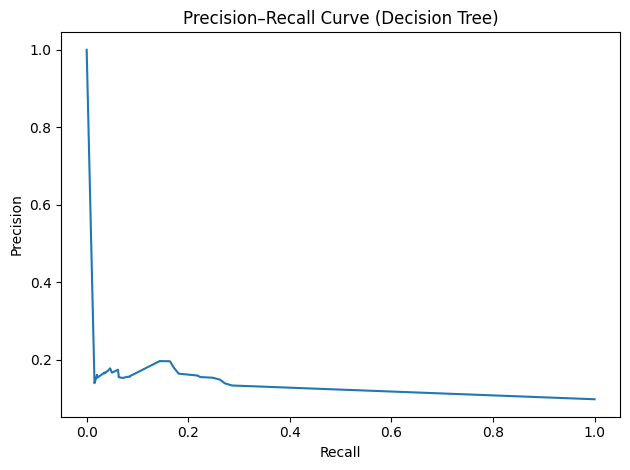

In [192]:
get_accuracy_metric(X_test,y_test,best_features,clf)

In [193]:
# the score is low probably if I will change the class weight to balance I will get better results
# but i want to give the model more influence on recall therefore I set the probablities

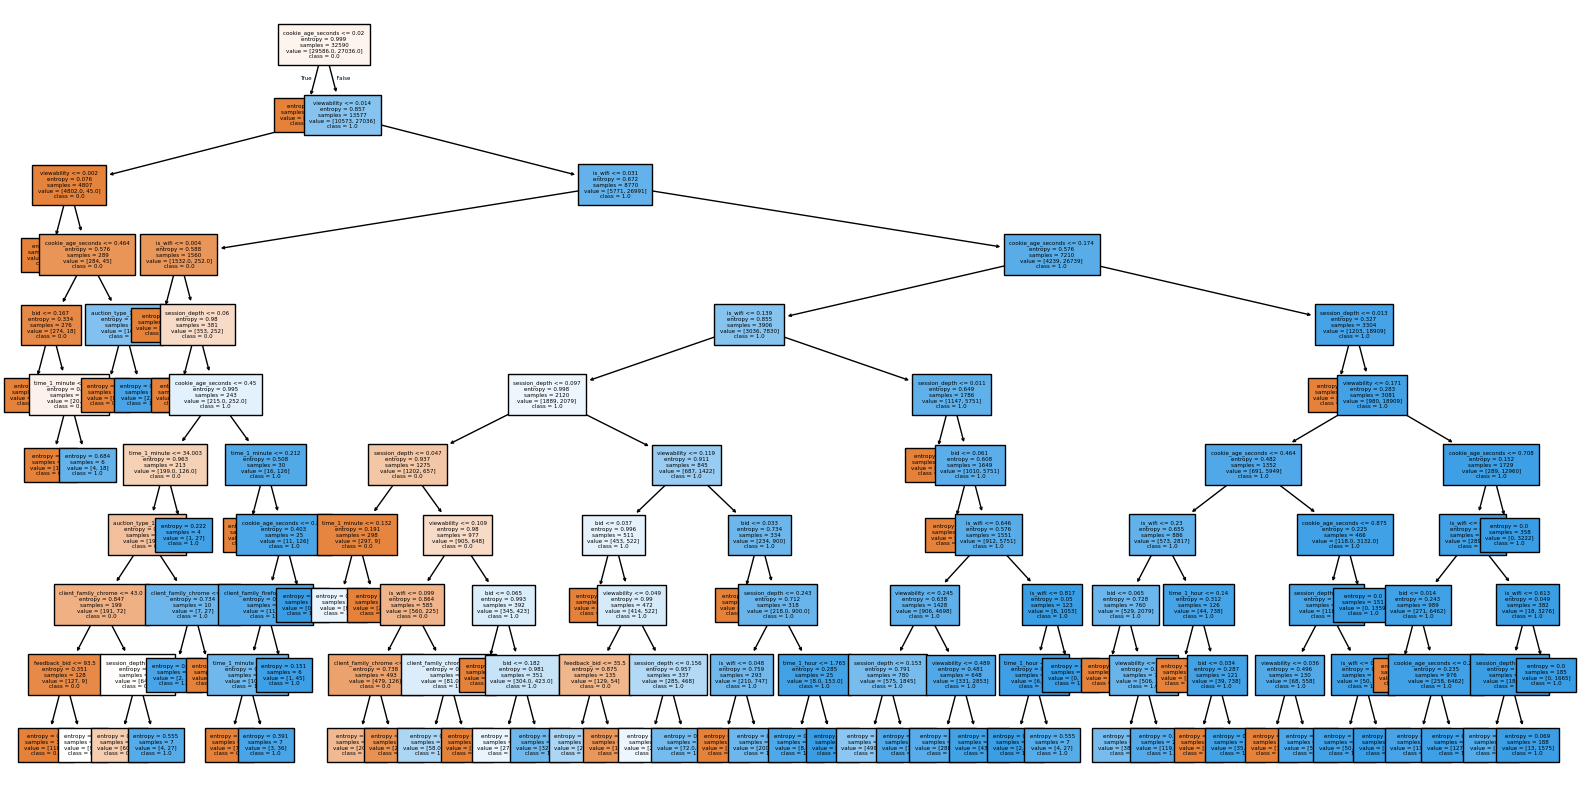

In [194]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=clf.classes_.astype(str),fontsize=4)
plt.show()

##run model 2- XGBOOST

### grid Search

In [195]:

ratio = (y_train==0).sum() / (y_train==1).sum()
#grid search parameters
param_grid = {
    'eval_metric':['aucpr'],
    'scale_pos_weight':[ratio],
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# model is decision tree
model_xgb=XGBClassifier()

In [196]:
best_parameters=Grid_Search_CV(X_train, y_train,model_xgb ,scoring_value,param_grid,tscv)

In [197]:
best_parameters

(np.float64(0.8841645332138425),
 {'colsample_bytree': 0.8,
  'eval_metric': 'aucpr',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100,
  'scale_pos_weight': np.float64(9.848868175765645),
  'subsample': 1.0,
  'random_state': 42})

### choose features by permutation importance

In [198]:
xgb = XGBClassifier(**best_parameters[1])

In [199]:
best_features =cv_perm_importance(xgb,X_train,y_train)

,0
postal_code_1,5.001691e-01
url_1,2.326721e-01
ad_slot_1,2.210606e-01
city_1,1.343603e-01
device_model_1,1.019188e-02
viewability,3.705099e-03
feedback_bid,3.414297e-04
bid,1.301348e-04
time_1_hour,1.169455e-04
cookie_age_seconds,8.240437e-05


In [200]:
best_features

['postal_code_1',
 'url_1',
 'ad_slot_1',
 'city_1',
 'device_model_1',
 'viewability',
 'feedback_bid',
 'bid',
 'time_1_hour',
 'cookie_age_seconds',
 'device_brand_1',
 'client_family_facebook_app',
 'state_code_1',
 'client_family_instagram_app',
 'is_wifi',
 'client_family_safari',
 'device_type_GAME_CONSOLE',
 'device_type_PERSONAL_COMPUTER',
 'device_type_TABLET',
 'detected_language_1']

In [201]:
len(best_features)

20

###train the model with best parmeters and features

In [202]:
xgb.fit(X_train[best_features], y_train)
y_pred = xgb.predict(X_test[best_features])

Test AP (PR-AUC): 0.1394 | ROC-AUC: 0.6044


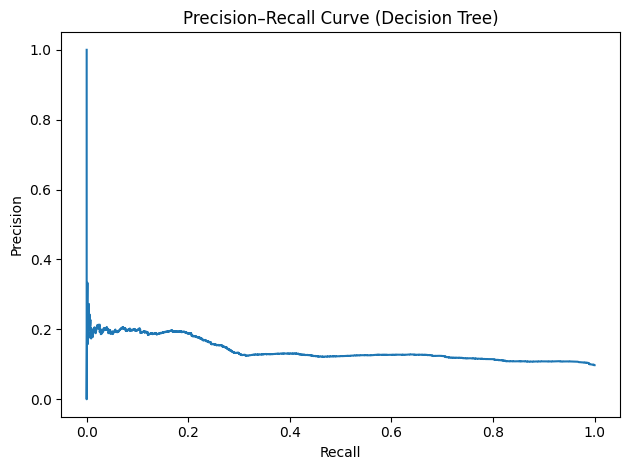

In [203]:
get_accuracy_metric(X_test,y_test,best_features,xgb)

In [204]:
#by PR-AUC and ROC-AUC XGBOOST show better results than the decision tree


In [205]:
def create_feature_importance(X,model):
    features=X.columns
    # Get feature importances from a trained tree model
    importances = model.feature_importances_
    feature_names = X.columns

    # Create a pandas Series for easier sorting
    feat_imp = pd.Series(importances, index=feature_names)

    # Sort by importance (optional)
    feat_imp = feat_imp.sort_values()

    # Plot vertically (horizontal bars)
    plt.figure(figsize=(8, 10))  # Adjust the size as needed
    plt.barh(feat_imp.index, feat_imp.values)
    plt.xlabel("Feature Importance")
    plt.title("Vertical Chart of Feature Importances")
    plt.tight_layout()
    plt.show()
    return

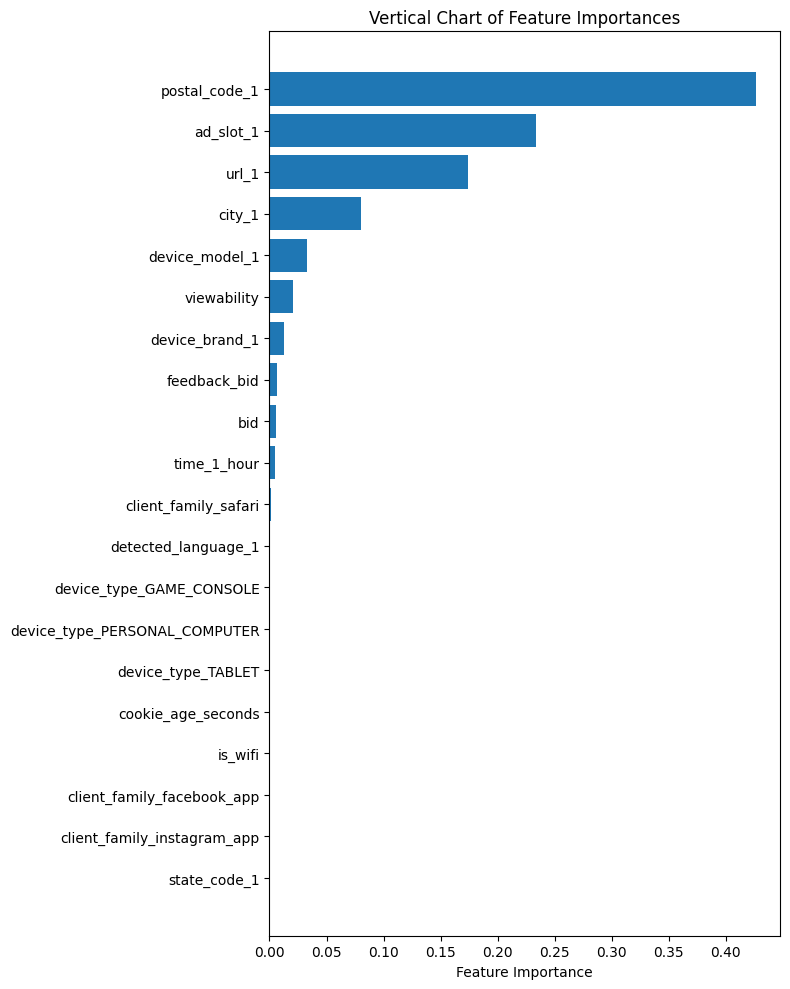

In [206]:
create_feature_importance(X_train[best_features],xgb)

In [ ]:
#by feature importance  the number of most influence features are 10 features, so my final answer for question 2 is :
features_question_2=['postal_code_1',
 'ad_slot_1',
  'url_1',
 'city_1',
 'device_model_1',
 'viewability',
 'device_brand_1',
 'feedback_bid',
 'bid',
 'time_1_hour',
]

# Question 3- classification model, won_bid

In [207]:
# i will filter differntlty the previous model so I will get the rows where there was a bid
df_bid_won=df_bid[df_bid['bidded']==1].copy()

In [208]:
df_bid_won.head(1).T

,4
time,2021-02-01 09:03:40.056427 UTC
user_id,24a0dda3-bcba-4e60-91f7-0916a3f180bf
domain,d62c4ae0304db7527a61b19f9149a189
url,5194f552aea6dea598a2b57cde4fb77e
ad_slot,e9c20ff10ceb2f62d0a2891a6277668f
country,US
postal_code,NaN
state_code,NaN
city,NaN
user_agent,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803893;...


In [209]:
df_bid_won.shape

(124152, 32)

### update null values

In [210]:
df_bid_won.isnull().sum().reset_index().rename(columns={0: 'count_nulls'}).query('count_nulls>0')

,index,count_nulls
6,postal_code,24644
7,state_code,3803
8,city,6073
9,user_agent,18
11,detected_language,102
13,device_brand,62740
14,device_model,62744
16,publisher_properties,47
24,feedback_bid,2
29,delta_feedback_bid,2


In [211]:
# change postal_code from text  to numeric
df_bid_won['postal_code']=pd.to_numeric(df_bid_won['postal_code'], errors='coerce')

In [212]:
df_bid_won=apply_na_strategy(df_bid_won)

,index,count_nulls
9,user_agent,18


(124150, 32)


### update categorial columns

In [213]:
df_bid_won.nunique()

,0
time,124143
user_id,124150
domain,1907
url,7295
ad_slot,5217
country,1
postal_code,16733
state_code,52
city,6736
user_agent,13962


In [214]:
# update two columns with  4/7 options with one hot codding

In [215]:
for col in cols_one_hot:
  df_bid_won = df_bid_won.join(
      pd.get_dummies(df_bid_won[col], prefix=col, dtype=int)
  )

In [216]:
df_bid_won[['device_type','device_type_GAME_CONSOLE','device_type_HIGHEND_PHONE','device_type_PERSONAL_COMPUTER','device_type_TABLET']].head()

,device_type,device_type_GAME_CONSOLE,device_type_HIGHEND_PHONE,device_type_PERSONAL_COMPUTER,device_type_TABLET
4,HIGHEND_PHONE,0,1,0,0
9,PERSONAL_COMPUTER,0,0,1,0
14,PERSONAL_COMPUTER,0,0,1,0
15,PERSONAL_COMPUTER,0,0,1,0
37,PERSONAL_COMPUTER,0,0,1,0


In [217]:
df_bid_won.loc[:,df_bid_won.columns.str.contains('client_family')].head()

,client_family,client_family_chrome,client_family_facebook_app,client_family_firefox,client_family_instagram_app,client_family_other,client_family_pinterest_app,client_family_safari
4,facebook_app,0,1,0,0,0,0,0
9,facebook_app,0,1,0,0,0,0,0
14,chrome,1,0,0,0,0,0,0
15,other,0,0,0,0,1,0,0
37,other,0,0,0,0,1,0,0


In [218]:
df_bid_won.shape

(124150, 43)

In [219]:
# update categorial with the mean conversion per categorial column
# in order to avoid data leackage we will filter the time by the time we will divided between train and test dfs

In [220]:
time_split_won=get_time_split(df_bid_won,0.7)

shape of train is  (86904, 44)
shape of test is  (37246, 44)


In [221]:
update_categorial_with_mean(df_bid_won,cols_categorial_mean_target,'won_bid',time_split_won)

In [222]:
df_bid_won.head(1).T

,4
time,2021-02-01 09:03:40.056427 UTC
user_id,24a0dda3-bcba-4e60-91f7-0916a3f180bf
domain,d62c4ae0304db7527a61b19f9149a189
url,5194f552aea6dea598a2b57cde4fb77e
ad_slot,e9c20ff10ceb2f62d0a2891a6277668f
country,US
postal_code,0.0
state_code,other
city,other
user_agent,[FBAN/FB4A;FBAV/303.0.0.30.122;FBBV/269803893;...


### column to use for the model

In [223]:
df_bid_won.columns[df_bid_won.columns.str.contains('_1')]

Index(['time_1', 'auction_type_1', 'time_1_hour', 'time_1_minute', 'domain_1',
       'url_1', 'ad_slot_1', 'postal_code_1', 'state_code_1', 'city_1',
       'detected_language_1', 'device_brand_1', 'device_model_1',
       'publisher_properties_1'],
      dtype='object')

In [224]:
# removed the column of ID due to unique value for each row
# removed the columns:  bidded  because thate is only one value
# removed the columns :'feedback_bid','delta_feedback_bid' and 'conversion' as we don't jhave this information when we try to predict the bid

numeric_cols=['cookie_age_seconds','is_wifi','viewability','session_depth','bid','time_1_hour','time_1_minute','won_bid','time_1']
categorial_cols=['auction_type_1','client_family_chrome', 'client_family_facebook_app','client_family_firefox', 'client_family_instagram_app','client_family_other', 'client_family_pinterest_app','client_family_safari',
                 'device_type_GAME_CONSOLE', 'device_type_HIGHEND_PHONE','device_type_PERSONAL_COMPUTER', 'device_type_TABLET','domain_1',
       'url_1', 'ad_slot_1', 'postal_code_1', 'state_code_1', 'city_1',
       'detected_language_1', 'device_brand_1', 'device_model_1',
       'publisher_properties_1']
col_to_use=numeric_cols+categorial_cols
print('there are {0} columns in the won model '.format(len(col_to_use)-1))

there are 30 columns in the won model 


In [225]:
df_bid_won_prod=df_bid_won[col_to_use].copy()

In [226]:
df_bid_won_prod.shape

(124150, 31)

### split the data

In [227]:
X_train, X_test, y_train, y_test = split_data_by_time(df_bid_won_prod,time_split_won,'won_bid')

won_bid
0.0    0.631651
1.0    0.368349
Name: proportion, dtype: float64
won_bid
0.0    0.609381
1.0    0.390619
Name: proportion, dtype: float64


shape of train is  (86904, 29)
shape of test is  (37246, 29)


# run model Catboost

In [228]:
# I used neg_log_loss because we want to get how close p(win|bid,row)
scoring_value="neg_log_loss"

In [229]:
# used default values and set logloss as the metric of scoring
cbc=CatBoostClassifier(
    loss_function="Logloss",            # proper prob. score
    eval_metric="Logloss",
    custom_metric=["PRAUC","AUC"],      # just to monitor
    auto_class_weights="Balanced",
    depth=6, learning_rate=0.1, iterations=1000,
    l2_leaf_reg=3, subsample=0.8, random_seed=42,
    verbose=100, early_stopping_rounds=100
)

###train the model with best parmeters

In [230]:
categorial_cols_catboost=['auction_type_1','client_family_chrome', 'client_family_facebook_app','client_family_firefox', 'client_family_instagram_app','client_family_other', 'client_family_pinterest_app','client_family_safari',
                 'device_type_GAME_CONSOLE', 'device_type_HIGHEND_PHONE','device_type_PERSONAL_COMPUTER', 'device_type_TABLET']

In [231]:
cbc.fit(X_train, y_train,cat_features=categorial_cols_catboost)
y_pred = cbc.predict(X_test)

0:	learn: 0.6308736	total: 85.7ms	remaining: 1m 25s
100:	learn: 0.3241129	total: 7.83s	remaining: 1m 9s
200:	learn: 0.3038858	total: 12.4s	remaining: 49.4s
300:	learn: 0.2913331	total: 18.8s	remaining: 43.6s
400:	learn: 0.2813630	total: 23.5s	remaining: 35.1s
500:	learn: 0.2728811	total: 29.3s	remaining: 29.2s
600:	learn: 0.2652397	total: 34.5s	remaining: 22.9s
700:	learn: 0.2583824	total: 39.2s	remaining: 16.7s
800:	learn: 0.2519208	total: 45.6s	remaining: 11.3s
900:	learn: 0.2456603	total: 50.3s	remaining: 5.52s
999:	learn: 0.2402232	total: 56.6s	remaining: 0us


In [232]:
def get_accuracy_metric_2(X_test,y_test,model):
  proba = model.predict_proba(X_test)[:,1]
  print("LogLoss :", log_loss(y_test, proba))
  print("PR-AUC  :", average_precision_score(y_test, proba))
  print("ROC-AUC :", roc_auc_score(y_test, proba))

In [233]:
get_accuracy_metric_2(X_test,y_test,cbc)

LogLoss : 0.7598776461176746
PR-AUC  : 0.7103761487654949
ROC-AUC : 0.7792198567898586


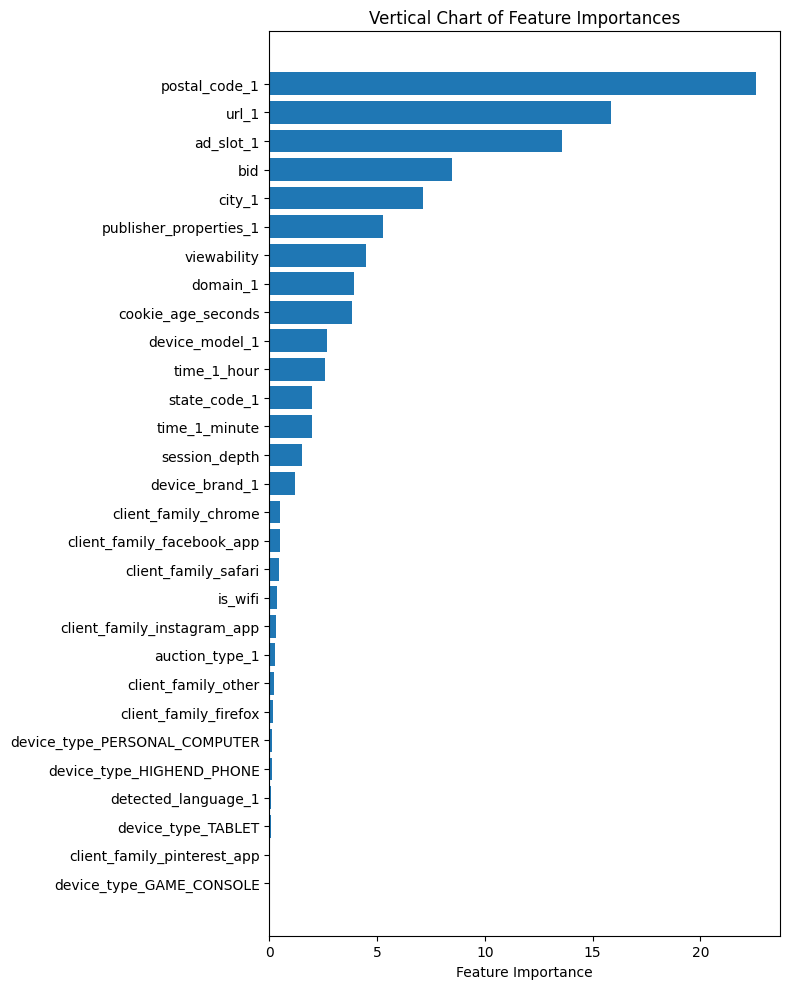

In [234]:
# get feature importance
create_feature_importance(X_train,cbc)

### get bid for url  

In [235]:
def _cat_proba(model, X, cat_cols=None):
    pool = Pool(X, cat_features=cat_cols) if cat_cols else X
    proba = model.predict_proba(pool)
    # CatBoost returns shape (n,2) for binary
    return proba[:, 1] if proba.ndim == 2 else proba

In [256]:
# function is create table of predict proba with verious bid based on catboost model
def bid_table_from_catboost(
    model,
    context_row,
    feature_cols,
    cat_cols = None,
    targets=(0.50, 0.70, 0.90),
    history_bids = None,
    bid_col = "bid",
    step_pct = 0.05,             # 5% jumps
    steps_down = 8, steps_up = 12,
    q_bounds=(0.01, 0.99),
):
    # --- baseline & bounds from history (if provided) ---
    hb = None if history_bids is None else pd.to_numeric(pd.Series(history_bids), errors="coerce").dropna()
    if hb is not None and len(hb):
        base_bid = hb.median()
        lo, hi = hb.quantile(list(q_bounds)).tolist()
    else:
        # fallback: use current value in context if present, else 1.0
        base_bid = float(context_row.get(bid_col, 1.0)) or 1.0
        lo, hi = max(1e-6, base_bid * 0.2), base_bid * 5.0

    print('low value bid is ',lo,' and high value bid  is ', hi)

    # --- candidate values on a 5% grid ---
    steps = np.arange(-steps_down, steps_up + 1)
    cand = np.clip(np.unique(np.round(base_bid * (1 + steps * step_pct), 6)), lo, hi)

    # --- build inputs & predict P(win) ---
    X = pd.DataFrame([context_row.reindex(feature_cols)] * len(cand), columns=feature_cols)
    X[bid_col] = cand  # no transform
    pred = _cat_proba(model, X, cat_cols)

    grid = (pd.DataFrame({"candidate_bid": cand, "pred_win": pred})
              .sort_values(["pred_win", "candidate_bid"]).reset_index(drop=True))

    # --- pick minimal candidate meeting each target ---
    best = {}
    pw, cb = grid["pred_win"].to_numpy(), grid["candidate_bid"].to_numpy()
    for t in map(float, targets):
        i = np.searchsorted(pw, t, side="left")
        best[t] = float(cb[-1] if i >= len(cb) else cb[i])
        grid[f"abs_err_to_{int(round(t*100))}p"] = (grid["pred_win"] - t).abs()

    grid["step_from_base_pct"] = grid["candidate_bid"] / base_bid - 1.0
    return best, grid.drop_duplicates()

In [270]:
#this function return the recomended bid , the predict proba of the model and the delta between requested precent and the precent in the table
def find_bid_for_target_catboost(table, target):
  if not {"candidate_bid", "pred_win"}.issubset(table.columns):
        raise ValueError("table must include 'candidate_bid' and 'pred_win' columns.")
  df = (table[["candidate_bid", "pred_win"]]
          .dropna()
          .drop_duplicates(subset="candidate_bid"))

  if df.empty:
        raise ValueError("table has no valid candidate rows.")

  df["abs_err"] = (df["pred_win"] - float(target)).abs()

  # break ties by choosing the smaller bid
  pick = df.sort_values(["abs_err", "candidate_bid"]).iloc[0]

  bid = float(pick["candidate_bid"])
  pred = float(pick["pred_win"])
  err  = float(pick["abs_err"])
  return bid, pred, err

### An example for recomended bid

In [271]:
#example of url , slot and target precent
url  = "d1d8815b6aba214f4f97c005908b2eb4"
slot = "fc962fde231a7ea7c7816fc83e817d51"
target_precent=0.55

row = (df_bid_won[(df_bid_won["url"] == url) & (df_bid_won["ad_slot"] == slot) &
                  (df_bid_won["time_1"] < time_split_won)]
         .sort_values("time_1").iloc[-1])             # pick latest row

feature_cols=[x for x in col_to_use if x not in ['won_bid','time_1']]

ctx_row = row.reindex(col_to_use)

hist= df_bid_won.loc[(df_bid_won["url"] == url) & (df_bid_won["ad_slot"] == slot) &
               (df_bid_won["time_1"] < time_split_won), "bid"].tolist()

In [272]:
best_bids, table = bid_table_from_catboost(
    model=cbc,
    context_row=ctx_row,
    feature_cols=feature_cols,
    cat_cols=categorial_cols_catboost,
    targets=(0.5, 0.7, 0.9),
    history_bids=hist,
    bid_col="bid",
)
print(best_bids)

low value bid is  1.1814661  and high value bid  is  2.2564981800000004
{0.5: 1.939719, 0.7: 2.2564981800000004, 0.9: 2.2564981800000004}


In [258]:
table

,candidate_bid,pred_win,abs_err_to_50p,abs_err_to_70p,abs_err_to_90p,step_from_base_pct
0,1.181466,0.404522,0.095478,0.295478,0.495478,-2.386357e-01
4,1.241420,0.430349,0.069651,0.269651,0.469651,-2.000000e-01
5,1.629364,0.433141,0.066859,0.266859,0.466859,5.000016e-02
6,1.551775,0.433155,0.066845,0.266845,0.466845,-1.110223e-16
7,1.706953,0.451769,0.048231,0.248231,0.448231,1.000003e-01
8,1.784541,0.473854,0.026146,0.226146,0.426146,1.499998e-01
9,1.319009,0.473932,0.026068,0.226068,0.426068,-1.499998e-01
10,1.862130,0.484696,0.015304,0.215304,0.415304,2.000000e-01
11,1.474186,0.488306,0.011694,0.211694,0.411694,-5.000016e-02
12,1.396598,0.493823,0.006177,0.206177,0.406177,-9.999968e-02


In [273]:
# show the recomended bid
bid, pred, err= find_bid_for_target_catboost(table, target_precent)
print("recomneded bid is {0}, the predict proba to win is {1} and the delta between the requested precent is {2}".format(bid, pred, err))

recomneded bid is 2.017308, the predict proba to win is 0.5349706876753714 and the delta between the requested precent is 0.015029312324628674


# Bonus

I would  store, per URL (and ad slot), the winning bid, the second-highest bid, and the auction type (first-price vs second-price).
Then I would  use simple thresholds to decide whether to route a request straight through or send it to a smarter bidder:


*   Cheap pass-through: If the historical winning bid is below a fixed price
  threshold, we skip modeling and bid that amount directly.


*   First-price auctions: Route to a bidder that estimates P(win | context,     bid). Only bid when both:
predicted probability ≥ a probability threshold, and price ≤ a price cap
for safety we can bid 1.2× the threshold price when we want extra win chance.

*  Second-price auctions: route to a bidder that predicts the clearing (second) price. If that predicted price meets our pricing threshold, the bidder adds a small premium and bids ~1.2× the predicted second price, provided the win-probability is above the probability threshold